In [1]:
%%bash
date
pwd

Sat Dec 31 12:25:42 EST 2022
/Users/ashish1610dhiman/gatech_projects/time_series_practice/notebooks/stocks_clustering


In [2]:
import sys
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

from sklearn.metrics import adjusted_mutual_info_score as ami

from tqdm.notebook import tqdm
import pickle

sys.version

/Users/ashish1610dhiman/opt/anaconda3/envs/time_series_practice/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


'3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:55:37) \n[Clang 14.0.6 ]'

In [3]:
%load_ext autoreload 
%autoreload 2

### Read the data files

In [4]:
df_ticker = pd.read_csv("../../data/sp500_ticker_sector.csv")
stock_prices = pd.read_csv("../../data/sp500_stock_prices.csv", header=[0, 1], low_memory=False)

In [5]:
close_prices = pd.read_csv("../../data/sp500_close_prices.csv",index_col=0)
close_prices.index = pd.to_datetime(close_prices.index)

In [6]:
close_prices.head()

A        AAL         AAP       AAPL       ABBV        ABC  \
2018-01-02  65.192200  51.647568   99.734360  40.950500  78.019852  86.671799   
2018-01-03  66.850937  51.014027  100.636864  40.943352  79.240784  86.994354   
2018-01-04  66.349472  51.335663  104.350220  41.133545  78.788864  86.800827   
2018-01-05  67.410294  51.316174  105.459518  41.601860  80.160431  87.851494   
2018-01-08  67.554947  50.809349  104.716858  41.447342  78.876083  89.307686   

                  ABT       ACGL         ACN        ADBE  ...        WYNN  \
2018-01-02  54.148956  29.433332  143.127060  177.699997  ...  154.734451   
2018-01-03  54.268688  29.459999  143.787598  181.039993  ...  153.058075   
2018-01-04  54.176582  29.570000  145.490158  183.220001  ...  153.886826   
2018-01-05  54.333172  29.453333  146.690323  185.339996  ...  154.913391   
2018-01-08  54.176582  29.456667  147.862579  185.039993  ...  152.850891   

                  XEL        XOM       XRAY        XYL        YUM         ZBH  \
2018-01-02  41.793236  65.379097  64.359596  64.108612  74.677452  115.880257   
2018-01-03  41.513504  66.663139  64.139153  64.890312  74.613380  116.683540   
2018-01-04  41.190063  66.755409  64.129547  65.323555  75.372978  116.515419   
2018-01-05  40.901604  66.701576  65.030602  65.201126  75.812241  117.673653   
2018-01-08  41.207550  67.001457  65.471581  65.436562  75.940369  117.897850   

                  ZBRA       ZION        ZTS  
2018-01-02  103.709999  44.222294  69.592262  
2018-01-03  105.769997  44.169952  69.912254  
2018-01-04  107.860001  44.353123  70.329208  
2018-01-05  109.540001  44.370567  71.134018  
2018-01-08  110.629997  44.152515  71.987320  

[5 rows x 479 columns]

### Plot all the sectors

In [7]:
df_ticker["GICS Sector"].value_counts()

Information Technology    76
Industrials               70
Financials                67
Health Care               63
Consumer Discretionary    56
Consumer Staples          33
Real Estate               31
Utilities                 30
Materials                 29
Communication Services    25
Energy                    23
Name: GICS Sector, dtype: int64

In [8]:
#we have 479 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(close_prices.T)
X_train.shape

(479, 1060, 1)

In [9]:
get_sector = lambda x: df_ticker[df_ticker.Symbol==x]["GICS Sector"].values[0]

In [10]:
y_train = np.array([get_sector(tick) for tick in close_prices.columns])
y_train.shape

(479,)

In [11]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12, 5]

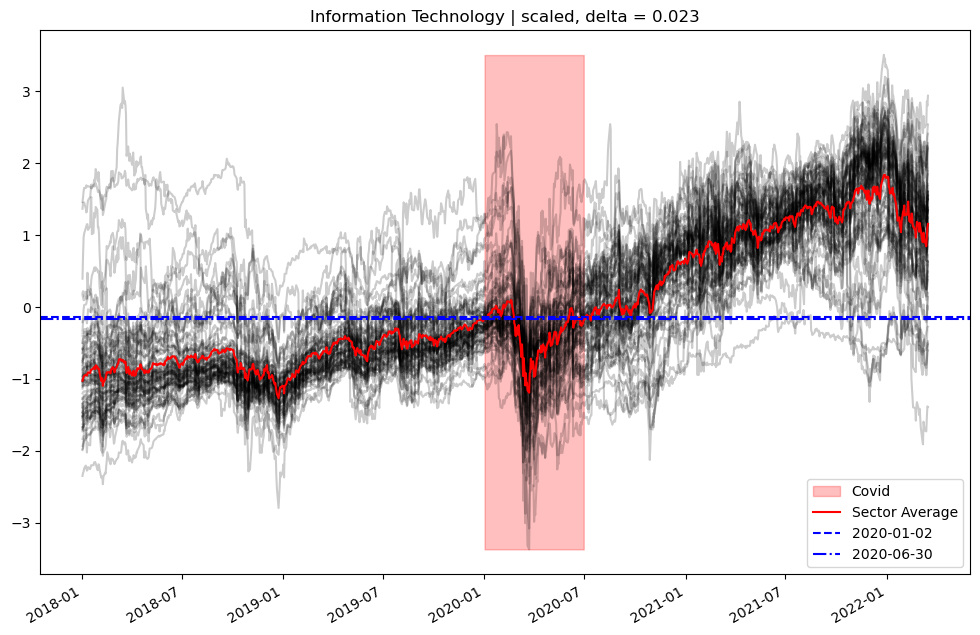

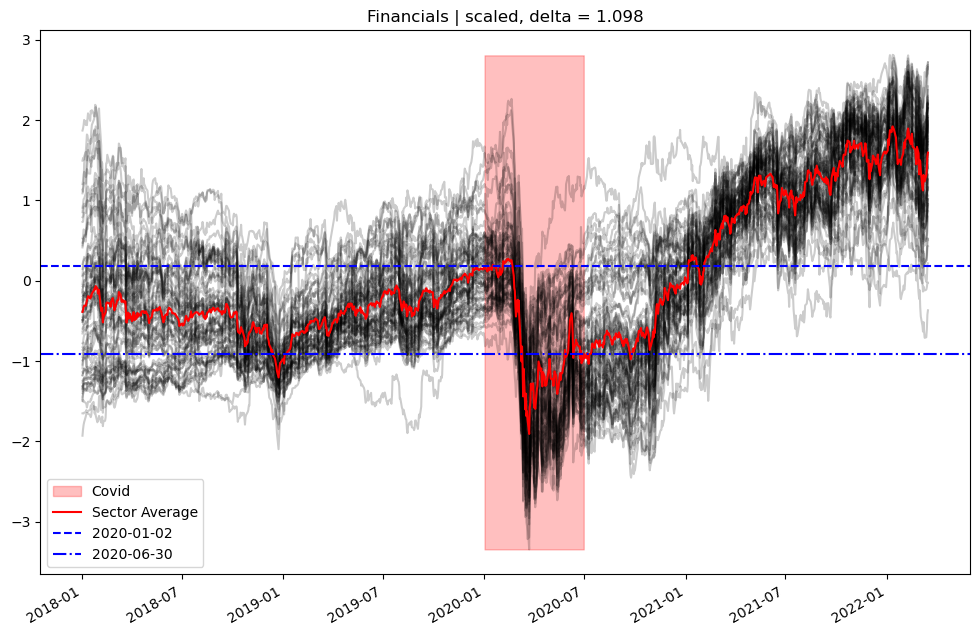

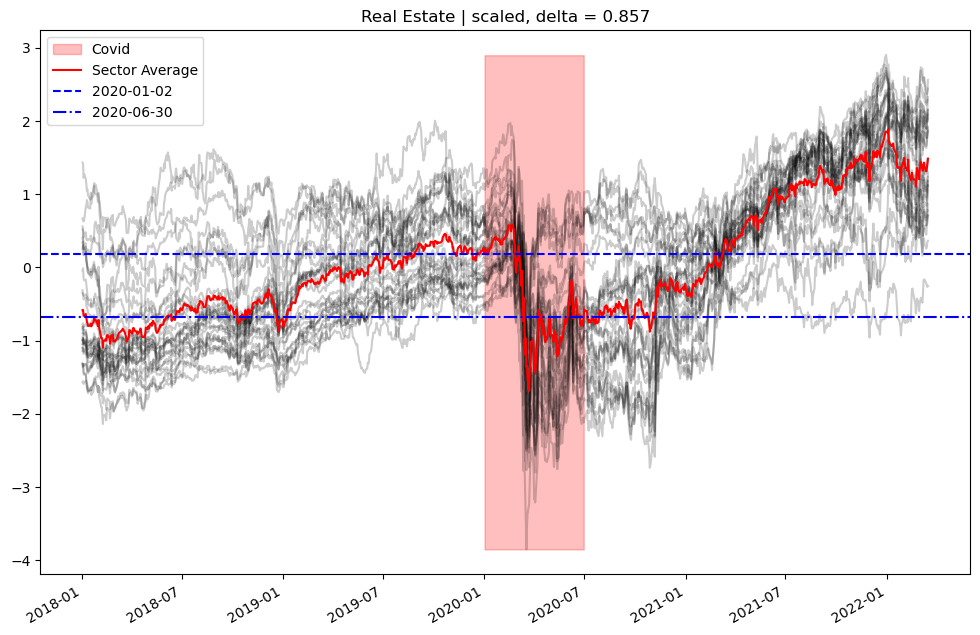

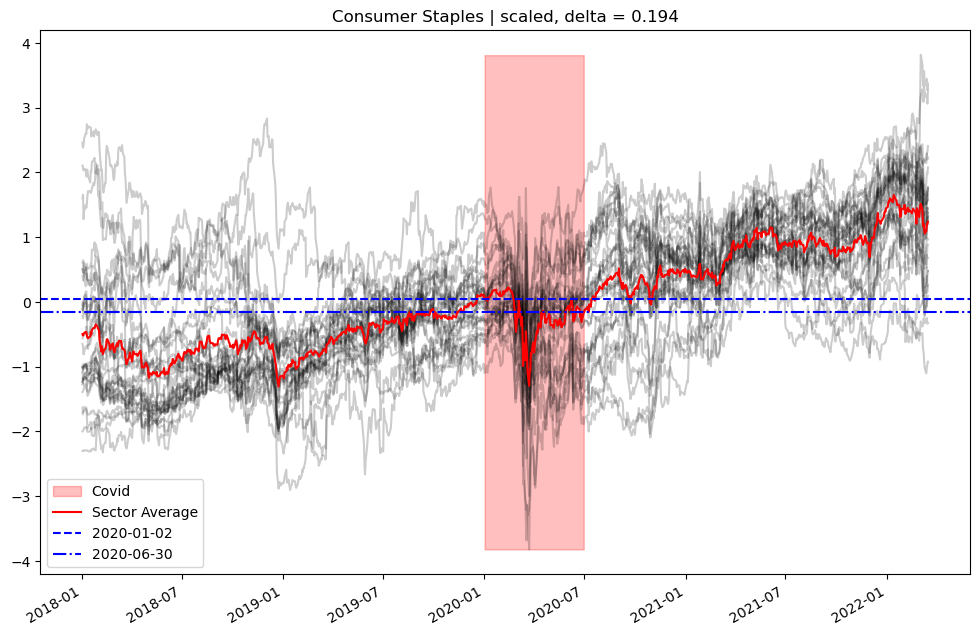

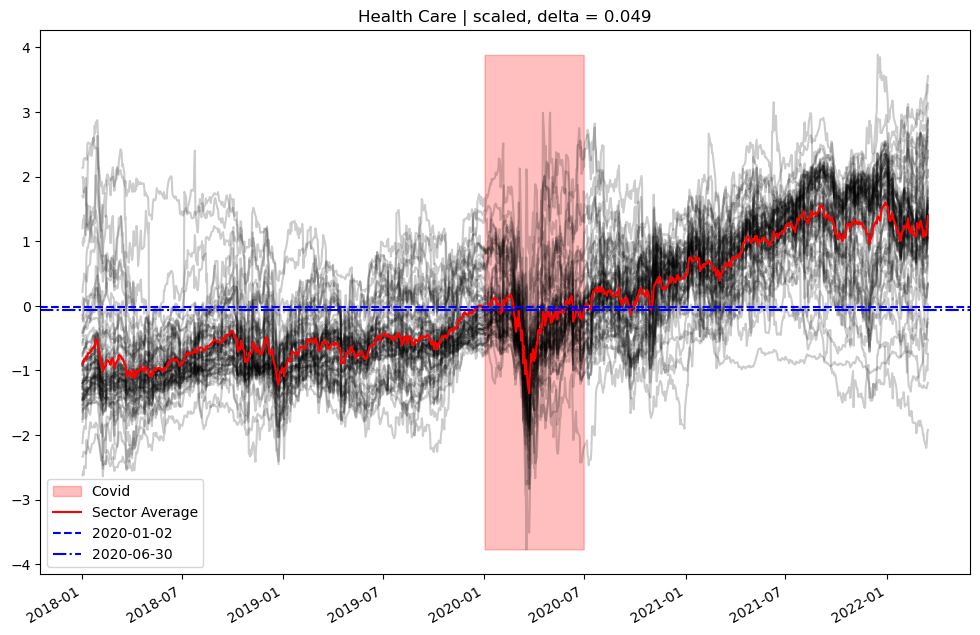

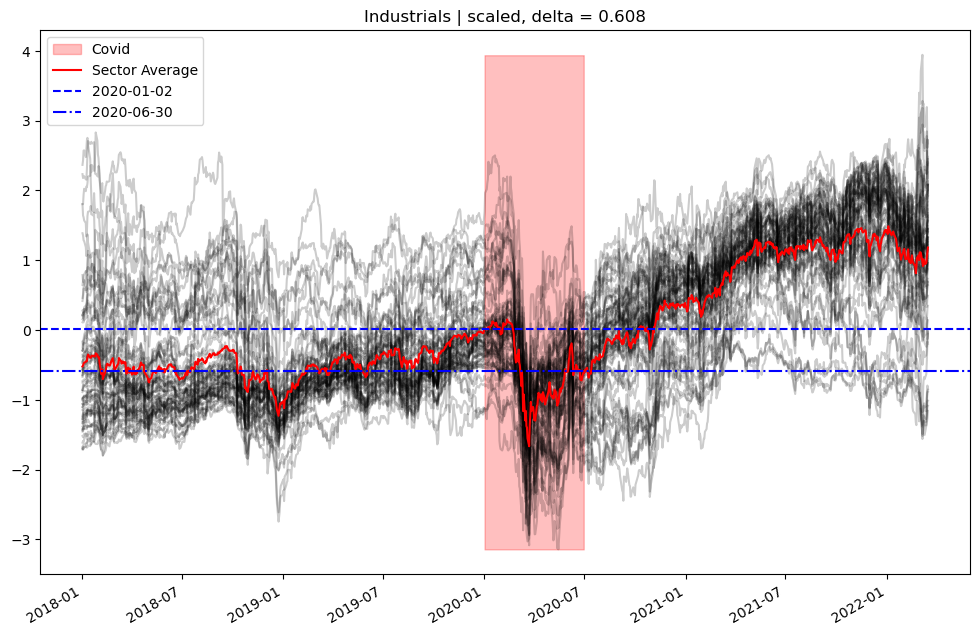

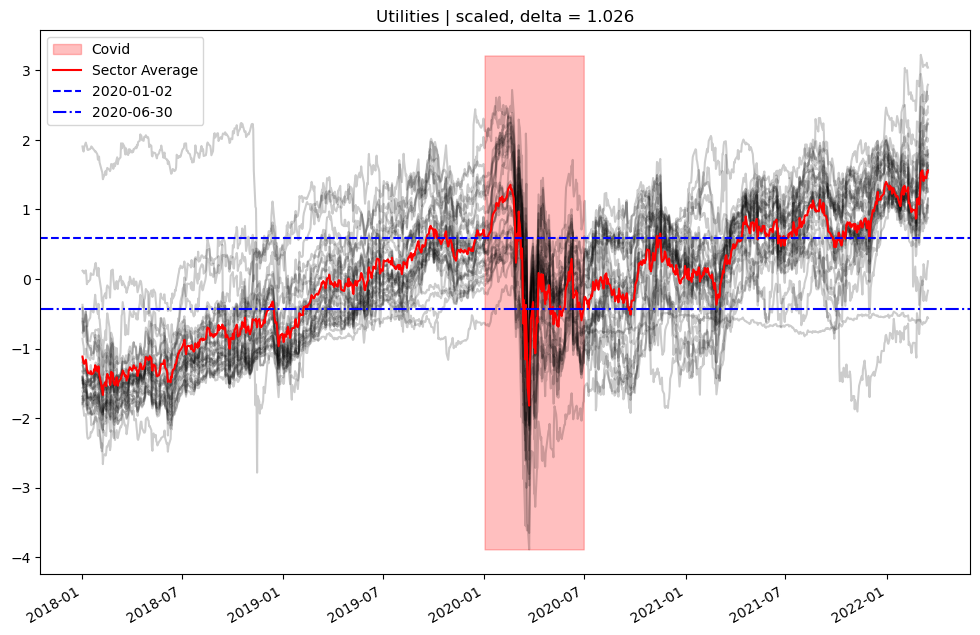

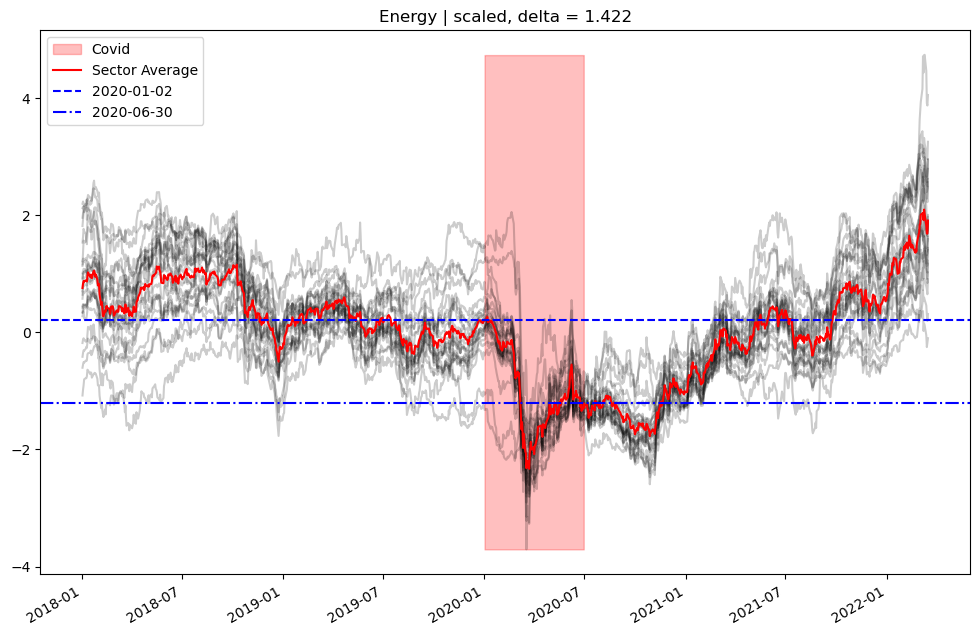

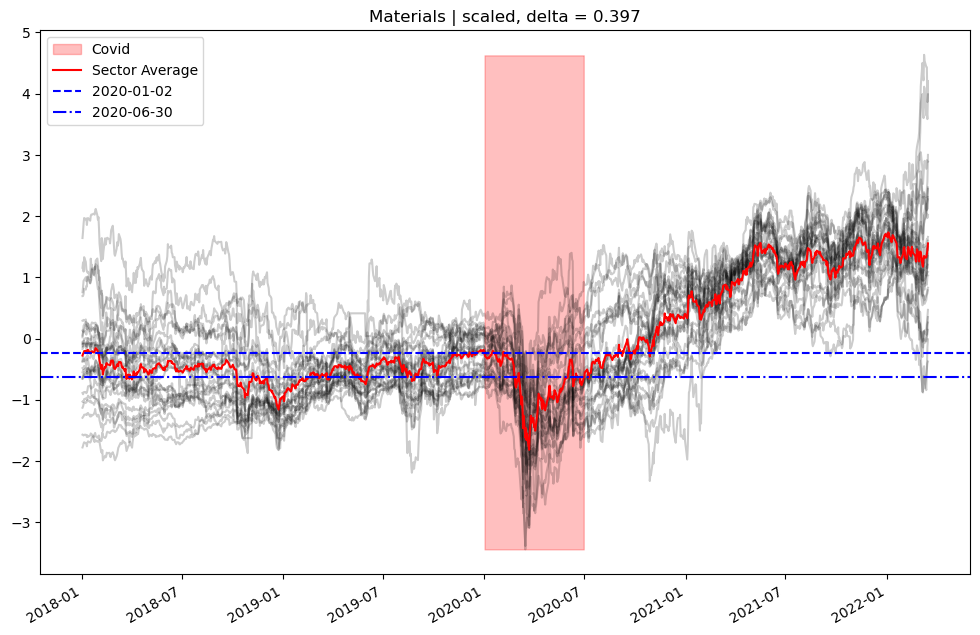

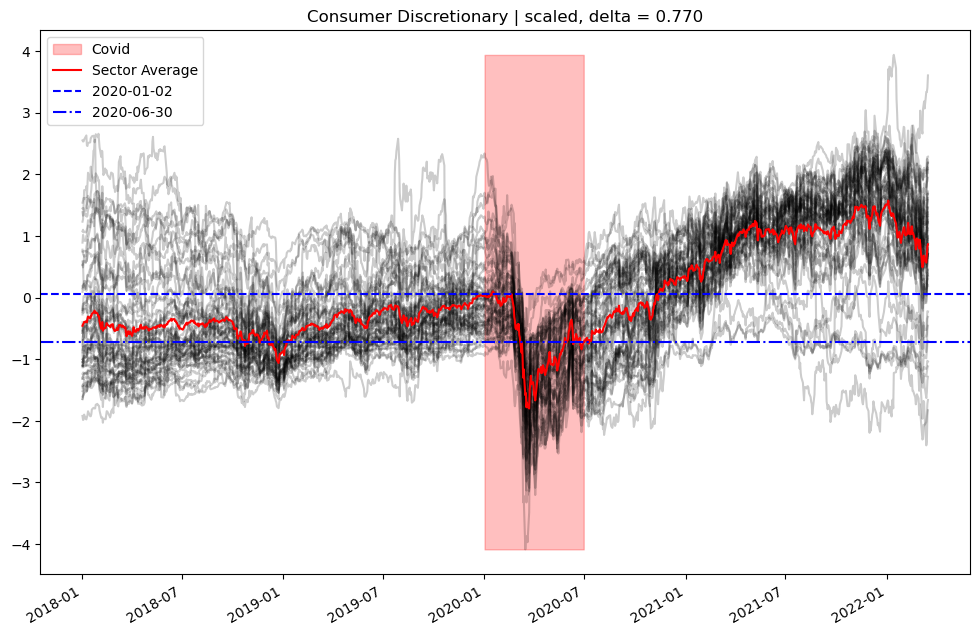

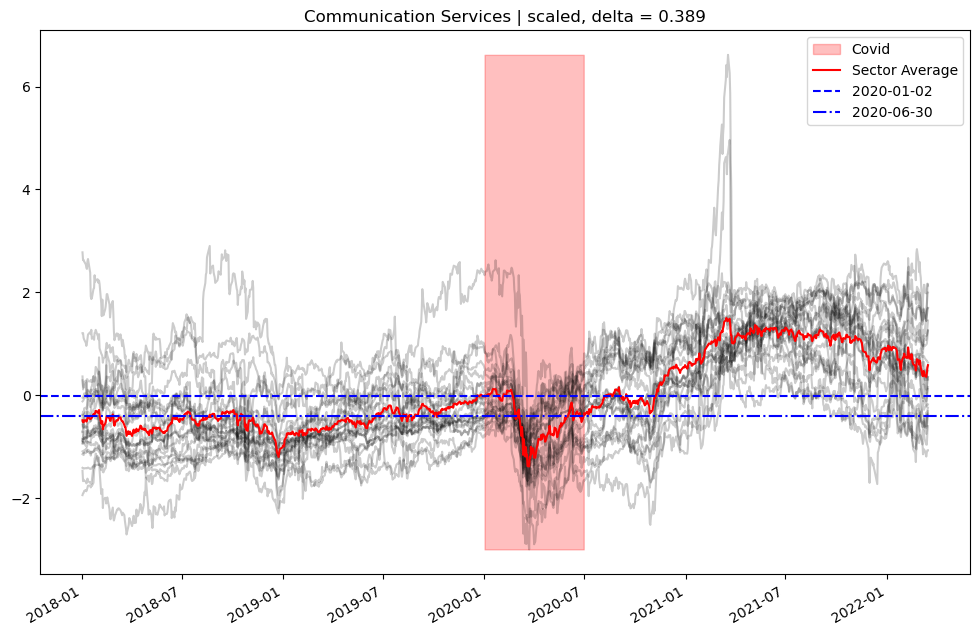

In [97]:
for sector in set(y_train):
    stocks_with_sector = y_train==sector
    df_subset = close_prices.loc[:,stocks_with_sector]
    sector_cols = df_subset.columns
    scaled_subset = pd.DataFrame(X_train[stocks_with_sector,:,0].T,\
                            columns = sector_cols)
    scaled_subset.index = df_subset.index
    val_at_id1 = scaled_subset.mean(axis=1)["2020-01-02"]
    val_at_id2 = scaled_subset.mean(axis=1)["2020-06-30"]
    delta = val_at_id1-val_at_id2
    scaled_subset.plot(title =f"{sector} | scaled, delta = {delta:.3f}", alpha = 0.2, c= "black", legend= False)
#     plt.gca().get_legend().remove()
    id1 = list(close_prices.index).index(pd.to_datetime("2020-01-02"))
    area_fill = plt.fill_betweenx(np.arange(scaled_subset.min().min(), scaled_subset.max().max(), 0.01),\
                      pd.to_datetime("2020-01-02"),pd.to_datetime("2020-06-30"),\
                      color="red",alpha=0.25, label = "Covid")
    avg = scaled_subset.mean(axis=1)
    line_a = plt.plot(avg.index, avg, color ="red", label = "Sector Average")
    line2 = plt.axhline(y=val_at_id1, label = "2020-01-02", color = "blue", linestyle = "dashed")
    line3 = plt.axhline(y=val_at_id2, label = "2020-06-30", color = "blue", linestyle = "-.")
    plt.legend([area_fill,line_a[0],line2,line3],["Covid","Sector Average","2020-01-02","2020-06-30"])
    plt.savefig(f"../../plots/sector_{sector}_plot.jpeg")

### Analyse the clusters

In [13]:
with open('../../models/result_dict_5_10.pickle', 'rb') as f:
    result1 = pickle.load(f)
    
with open('../../models/result_dict_10_15.pickle', 'rb') as f:
    result2 = pickle.load(f)
    
with open('../../models/result_dict_15_20.pickle', 'rb') as f:
    result3 = pickle.load(f)    

In [14]:
result_dict = {**result1, **result2, **result3}
result_df = pd.DataFrame.from_dict(result_dict,orient="index")
result_df.columns = ["model","y_pred","ami"]
result_df.head()

model  \
5  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
6  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
7  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
8  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
9  TimeSeriesKMeans(max_iter_barycenter=10, metri...   

                                              y_pred       ami  
5  [2, 4, 2, 2, 0, 0, 2, 3, 2, 2, 2, 0, 2, 2, 2, ...  0.069633  
6  [0, 5, 0, 0, 4, 4, 0, 3, 0, 0, 0, 4, 0, 2, 3, ...  0.105111  
7  [2, 0, 1, 2, 3, 2, 1, 4, 2, 1, 1, 2, 1, 1, 1, ...  0.075426  
8  [0, 1, 5, 0, 4, 4, 0, 7, 0, 5, 0, 4, 0, 5, 7, ...  0.104306  
9  [7, 6, 1, 7, 2, 2, 5, 1, 7, 5, 7, 7, 1, 4, 1, ...  0.098642

In [15]:
result_df["inertia"] = result_df["model"].apply(lambda x: x.inertia_)

In [16]:
np.unique(result_df["y_pred"][8])

array([0, 1, 2, 3, 4, 5, 6, 7])

In [17]:
np.unique(result_df["model"][8].labels_)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [33]:
result_df[["ami","inertia"]].style.highlight_max(color = 'lightgreen', axis = 0,subset=["ami"]\
                                                ).highlight_min(color = 'lightgreen', axis = 0,subset=["inertia"]\
                                                )

### Elbow Plot

<AxesSubplot: >

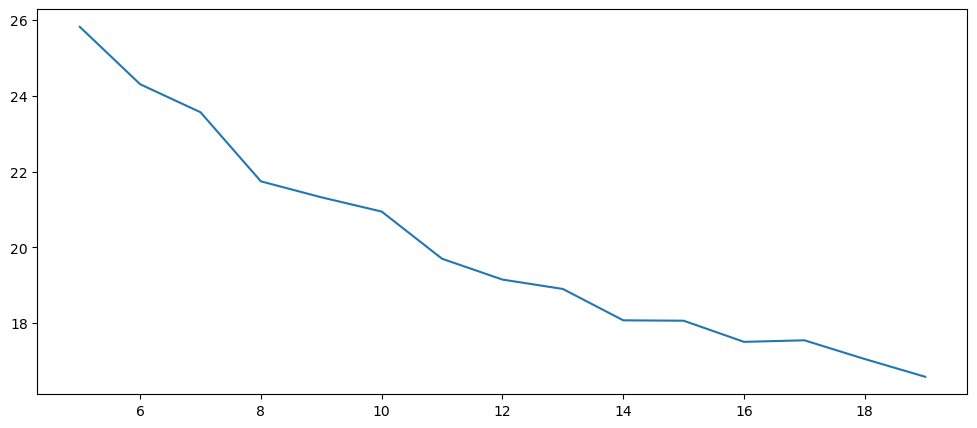

In [19]:
result_df["inertia_lag1"] = result_df["inertia"].shift(1)
result_df["delta_interia"] = result_df["inertia_lag1"]-result_df["inertia"]

fig, ax = plt.subplots() 
result_df["inertia"].plot(ax = ax) 

In [20]:
result_df

model  \
5   TimeSeriesKMeans(max_iter_barycenter=10, metri...   
6   TimeSeriesKMeans(max_iter_barycenter=10, metri...   
7   TimeSeriesKMeans(max_iter_barycenter=10, metri...   
8   TimeSeriesKMeans(max_iter_barycenter=10, metri...   
9   TimeSeriesKMeans(max_iter_barycenter=10, metri...   
10  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
11  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
12  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
13  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
14  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
15  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
16  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
17  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
18  TimeSeriesKMeans(max_iter_barycenter=10, metri...   
19  TimeSeriesKMeans(max_iter_barycenter=10, metri...   

                                               y_pred       ami    inertia  \
5   [2, 4, 2, 2, 0, 0, 2, 3, 2, 2, 2, 0, 2, 2, 2, ...  0.069633  25.824961   
6   [0, 5, 0, 0, 4, 4, 0, 3, 0, 0, 0, 4, 0, 2, 3, ...  0.105111  24.308446   
7   [2, 0, 1, 2, 3, 2, 1, 4, 2, 1, 1, 2, 1, 1, 1, ...  0.075426  23.568359   
8   [0, 1, 5, 0, 4, 4, 0, 7, 0, 5, 0, 4, 0, 5, 7, ...  0.104306  21.744971   
9   [7, 6, 1, 7, 2, 2, 5, 1, 7, 5, 7, 7, 1, 4, 1, ...  0.098642  21.324224   
10  [7, 6, 1, 7, 2, 2, 5, 9, 7, 5, 7, 7, 1, 4, 5, ...  0.101087  20.947324   
11  [3, 1, 8, 3, 0, 0, 3, 6, 3, 8, 3, 0, 3, 9, 8, ...  0.097355  19.701650   
12  [7, 2, 5, 7, 11, 11, 7, 5, 7, 9, 7, 11, 7, 9, ...  0.124670  19.152297   
13  [12, 6, 1, 12, 2, 7, 12, 9, 12, 12, 12, 7, 1, ...  0.108890  18.904622   
14  [6, 7, 11, 6, 0, 0, 6, 8, 6, 6, 6, 0, 11, 2, 2...  0.088967  18.076675   
15  [12, 6, 1, 12, 2, 7, 12, 9, 12, 12, 12, 7, 1, ...  0.114366  18.066259   
16  [12, 6, 1, 12, 7, 7, 12, 9, 12, 12, 12, 7, 1, ...  0.115453  17.508462   
17  [12, 6, 1, 12, 7, 7, 12, 9, 12, 12, 12, 7, 1, ...  0.115302  17.549363   
18  [10, 17, 16, 10, 4, 4, 10, 5, 10, 10, 10, 4, 1...  0.107764  17.054832   
19  [12, 6, 1, 12, 17, 17, 12, 9, 12, 12, 12, 17, ...  0.112015  16.586638   

    inertia_lag1  delta_interia  
5            NaN            NaN  
6      25.824961       1.516515  
7      24.308446       0.740087  
8      23.568359       1.823388  
9      21.744971       0.420747  
10     21.324224       0.376900  
11     20.947324       1.245674  
12     19.701650       0.549352  
13     19.152297       0.247675  
14     18.904622       0.827947  
15     18.076675       0.010417  
16     18.066259       0.557796  
17     17.508462      -0.040901  
18     17.549363       0.494531  
19     17.054832       0.468194

### Cross tab

In [21]:
result_df.loc[8]["model"]

TimeSeriesKMeans(max_iter_barycenter=10, metric='dtw', n_clusters=8, n_init=2,
                 n_jobs=-1, random_state=77, tol=0.01, verbose=True)

In [22]:
get_sub_sector = lambda x: df_ticker[df_ticker.Symbol==x]["GICS Sub-Industry"].values[0]

In [121]:
y_pred1 = result_df.loc[8]["y_pred"]
cross = pd.DataFrame()
cross["stokcs"] = close_prices.columns
cross["sector"] = y_train
cross["sub_sector"] = np.array([get_sub_sector(tick) for tick in close_prices.columns])
cross["predicted_label"] = y_pred1

In [104]:
cross["predicted_label"].value_counts()

0    153
4     72
5     63
7     58
6     45
2     38
1     34
3     16
Name: predicted_label, dtype: int64

In [24]:
res1 = pd.crosstab(cross.sector, cross.predicted_label, margins=True, margins_name="Total")
res2 = pd.crosstab(cross.sub_sector, cross.predicted_label, margins=True, margins_name="Total")

In [25]:
writer = pd.ExcelWriter("crosstab.xlsx", engine='xlsxwriter')
# Write each dataframe to a different worksheet.
res1.to_excel(writer, sheet_name='Sector')
res2.to_excel(writer, sheet_name='Sub_sector')
# Close the Pandas Excel writer and output the Excel file.
writer.close()

In [26]:
res1.style.highlight_max(color = 'lightgreen', axis = 1).highlight_max(color = 'lightgreen', axis = 0)

In [27]:
res2.style.highlight_max(color = 'lightgreen', axis = 1).highlight_max(color = 'lightgreen', axis = 0)

In [28]:
cross["predicted_label"].value_counts()

0    153
4     72
5     63
7     58
6     45
2     38
1     34
3     16
Name: predicted_label, dtype: int64

In [29]:
cross["sub_sector"].value_counts()

Health Care Equipment    18
Semiconductors           15
Electric Utilities       13
Application Software     12
Regional Banks           12
                         ..
Diversified Chemicals     1
Copper                    1
Consumer Electronics      1
Agricultural Products     1
Household Appliances      1
Name: sub_sector, Length: 120, dtype: int64

### Plot Clusters

In [30]:
matplotlib.rcParams['figure.figsize'] = [12, 8]

### Cluster Avg plot

In [100]:
all_cluster_avg = pd.DataFrame()
for cluster in set(y_pred1):
    stocks_with_cluster = y_pred1==cluster
    df_subset = close_prices.loc[:,stocks_with_cluster]
    sector_cols = df_subset.columns
    scaled_subset = pd.DataFrame(X_train[stocks_with_cluster,:,0].T,\
                            columns = sector_cols)
    scaled_subset.index = df_subset.index
    all_cluster_avg[f"Cluster_{cluster}"] = scaled_subset.mean(axis=1)
#     id1 = list(close_prices.index).index(pd.to_datetime("2020-01-02"))
    
#     sector_avg = scaled_subset

<AxesSubplot: title={'center': 'Average of all clsuters'}>

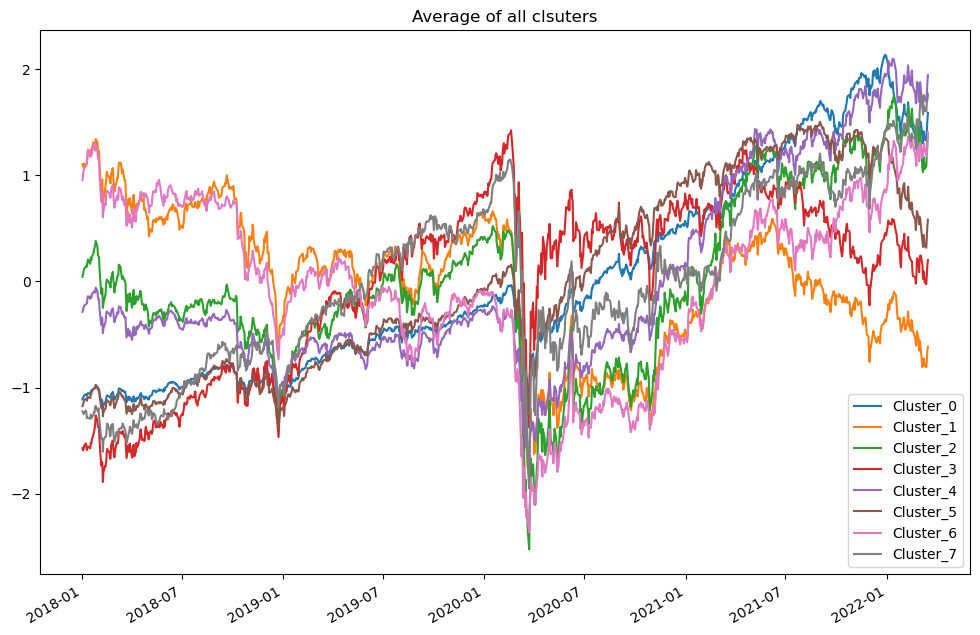

In [103]:
all_cluster_avg.plot(title = "Average of all clsuters")

In [ ]:
plt.fill_betweenx(np.arange(scaled_subset.min().min(), scaled_subset.max().max(), 0.01),\
                      pd.to_datetime("2020-01-02"),pd.to_datetime("2020-06-30"),\
                      color="red",alpha=0.25, label = "Covid")
    scaled_subset.mean(axis=1).plot(color="red")
    area_fill = plt.fill_betweenx(np.arange(scaled_subset.min().min(), scaled_subset.max().max(), 0.01),\
                      pd.to_datetime("2020-01-02"),pd.to_datetime("2020-06-30"),\
                      color="red",alpha=0.25, label = "Covid")
    avg = scaled_subset.mean(axis=1)
    line_a = plt.plot(avg.index, avg, color ="red", label = "Cluster Average")
    line2 = plt.axhline(y=val_at_id1, label = "2020-01-02", color = "blue", linestyle = "dashed")
    line3 = plt.axhline(y=val_at_id2, label = "2020-06-30", color = "blue", linestyle = "-.")
    plt.legend([area_fill,line_a[0],line2,line3],["Covid","Cluster Average","2020-01-02","2020-06-30"])
    plt.savefig(f"../../plots/cluster_all_plot.jpeg")

### Cluster plot

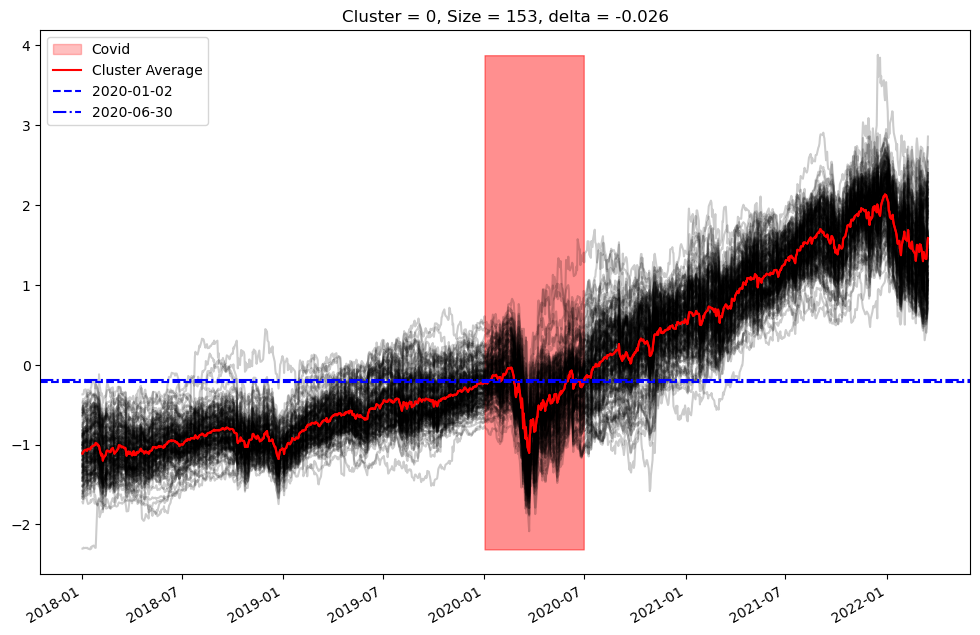

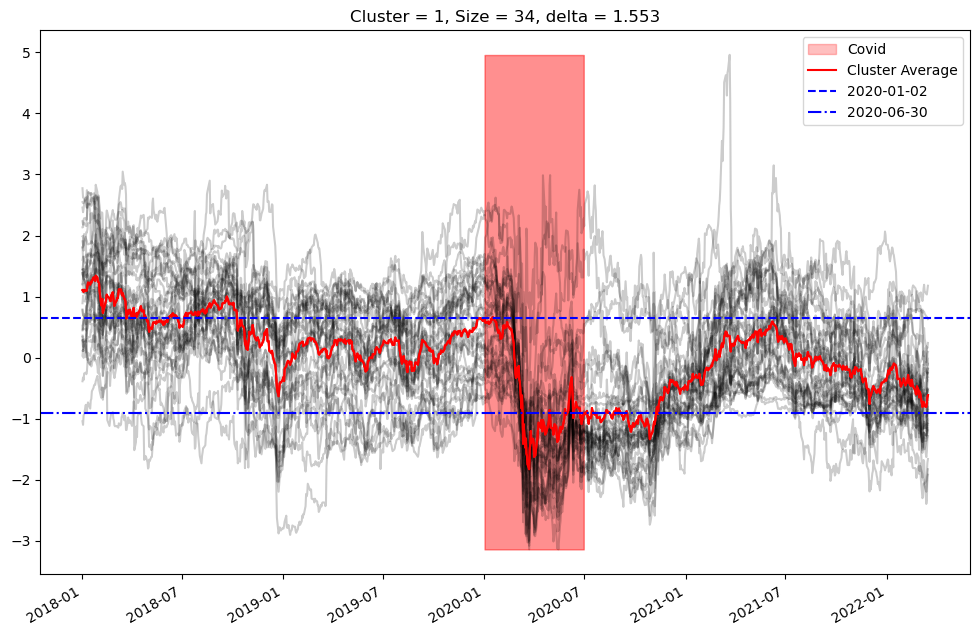

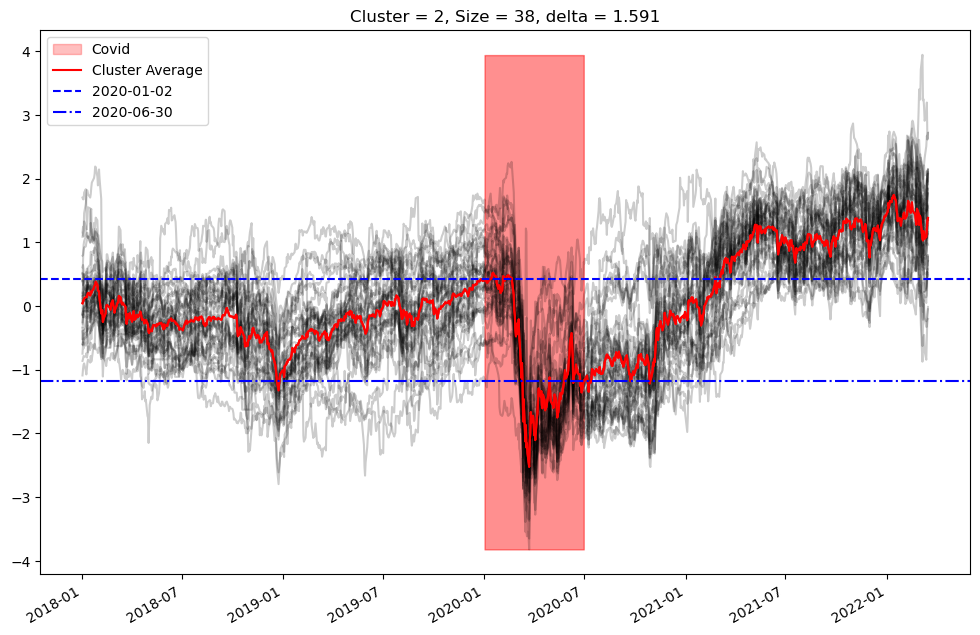

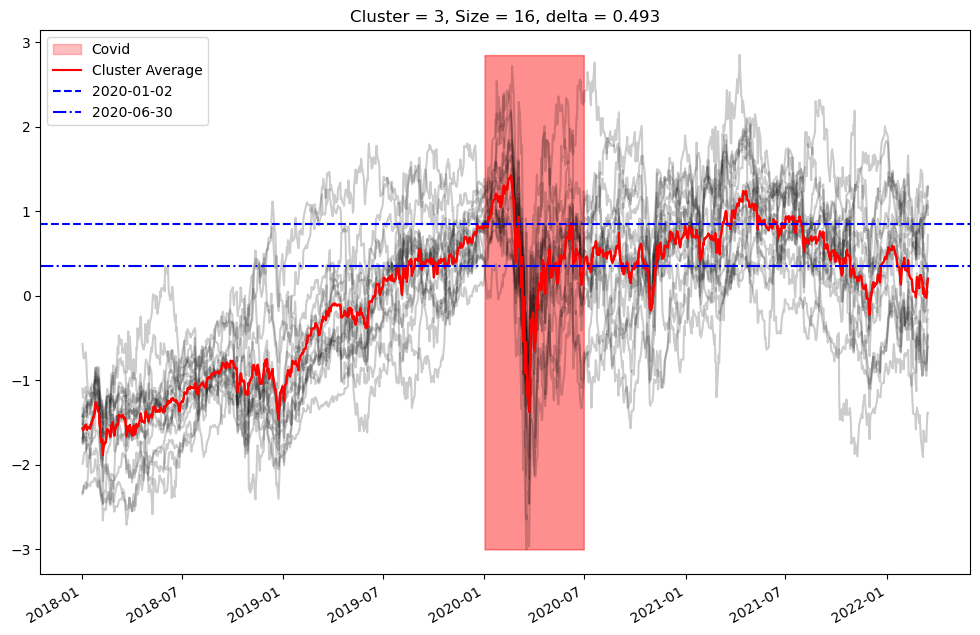

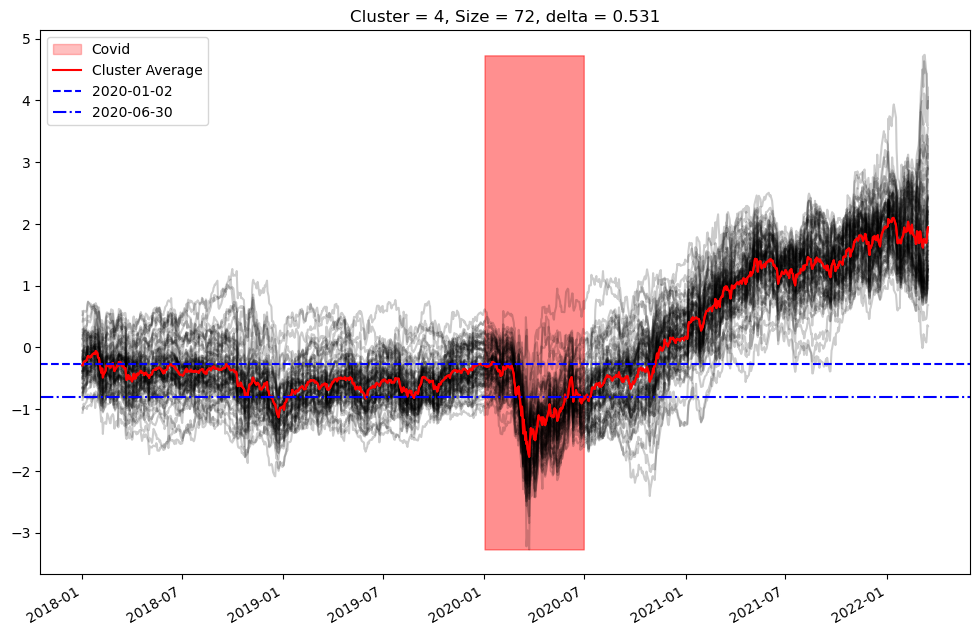

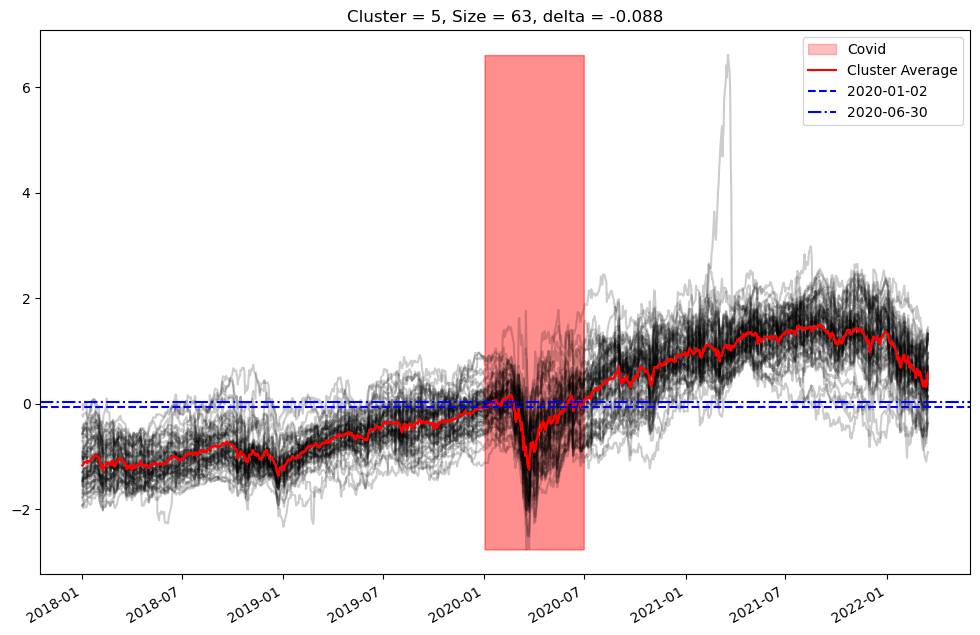

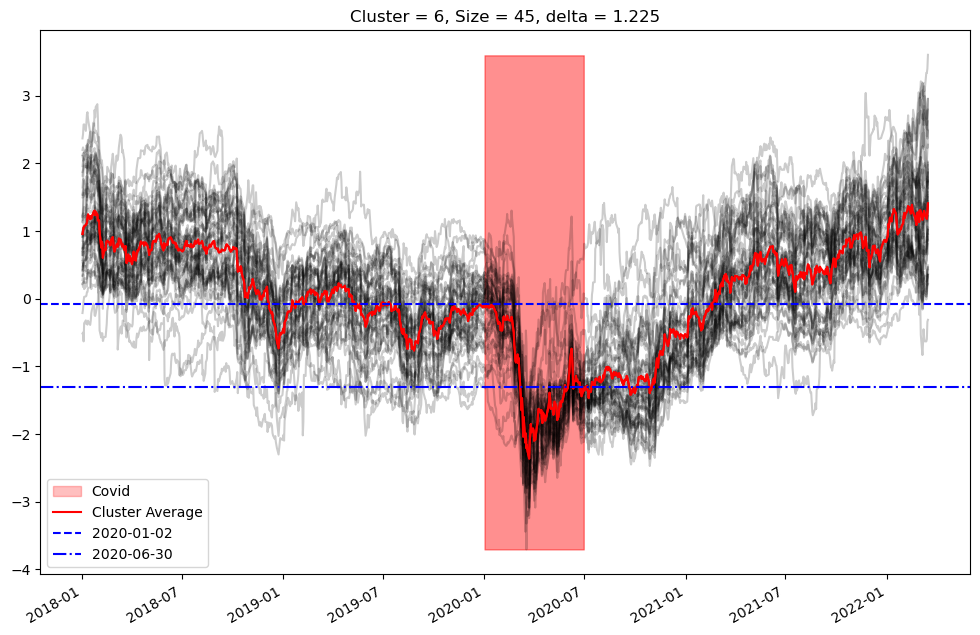

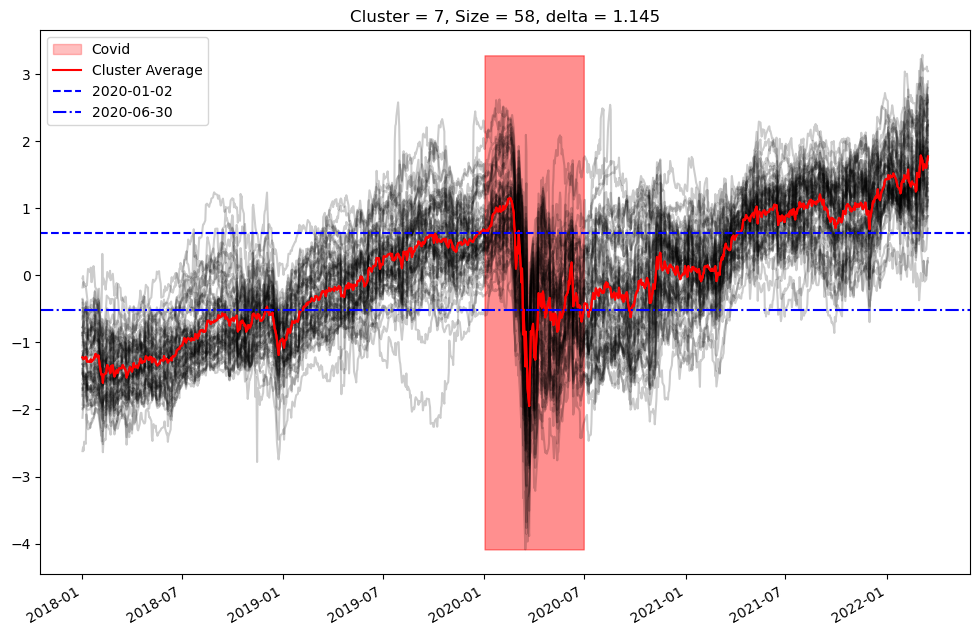

In [98]:
for cluster in set(y_pred1):
    stocks_with_cluster = y_pred1==cluster
    df_subset = close_prices.loc[:,stocks_with_cluster]
    sector_cols = df_subset.columns
    scaled_subset = pd.DataFrame(X_train[stocks_with_cluster,:,0].T,\
                            columns = sector_cols)
    scaled_subset.index = df_subset.index
    n_cluster = stocks_with_cluster.sum()
    val_at_id1 = scaled_subset.mean(axis=1)["2020-01-02"]
    val_at_id2 = scaled_subset.mean(axis=1)["2020-06-30"]
    delta = val_at_id1-val_at_id2
    scaled_subset.plot(title =f"Cluster = {cluster}, Size = {n_cluster}, delta = {delta:.3f}",\
                       alpha = 0.2, legend = False, c= "black")
#     id1 = list(close_prices.index).index(pd.to_datetime("2020-01-02"))
    plt.fill_betweenx(np.arange(scaled_subset.min().min(), scaled_subset.max().max(), 0.01),\
                      pd.to_datetime("2020-01-02"),pd.to_datetime("2020-06-30"),\
                      color="red",alpha=0.25, label = "Covid")
    scaled_subset.mean(axis=1).plot(color="red")
    area_fill = plt.fill_betweenx(np.arange(scaled_subset.min().min(), scaled_subset.max().max(), 0.01),\
                      pd.to_datetime("2020-01-02"),pd.to_datetime("2020-06-30"),\
                      color="red",alpha=0.25, label = "Covid")
    avg = scaled_subset.mean(axis=1)
    line_a = plt.plot(avg.index, avg, color ="red", label = "Cluster Average")
    line2 = plt.axhline(y=val_at_id1, label = "2020-01-02", color = "blue", linestyle = "dashed")
    line3 = plt.axhline(y=val_at_id2, label = "2020-06-30", color = "blue", linestyle = "-.")
    plt.legend([area_fill,line_a[0],line2,line3],["Covid","Cluster Average","2020-01-02","2020-06-30"])
    plt.savefig(f"../../plots/cluster_{cluster}_plot.jpeg")
#     sector_avg = scaled_subset

### Top sub sectors within a group

In [35]:
cross.columns

Index(['sector', 'sub_sector', 'predicted_label'], dtype='object')

In [43]:
res3 = cross[["predicted_label","sub_sector"]].value_counts()

sub_sector
Health Care Equipment                           11
Semiconductors                                   8
Life Sciences Tools & Services                   6
Application Software                             6
Financial Exchanges & Data                       6
                                                ..
Hypermarkets & Super Centers                     1
Independent Power Producers & Energy Traders     1
Industrial Gases                                 1
Industrial REITs                                 1
Agricultural & Farm Machinery                    1
Length: 71, dtype: int64

In [64]:
[x for x in dir(ax) if "right" in x]

['_right_title']

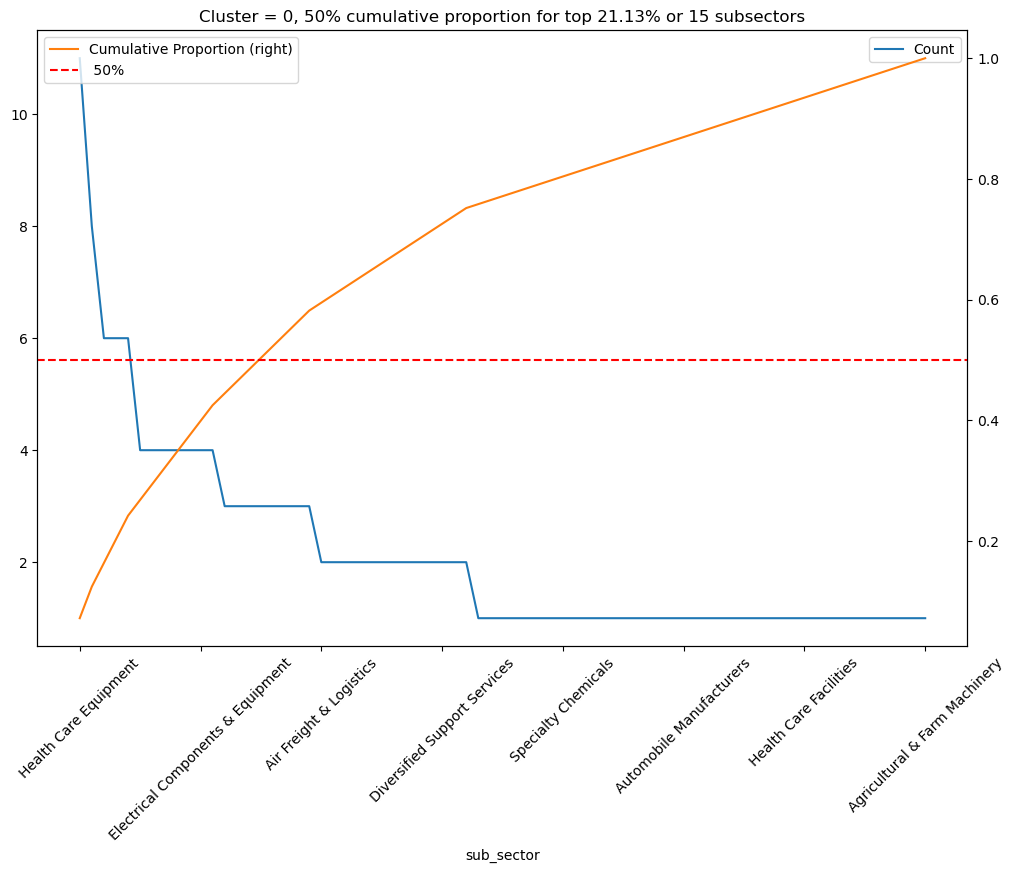

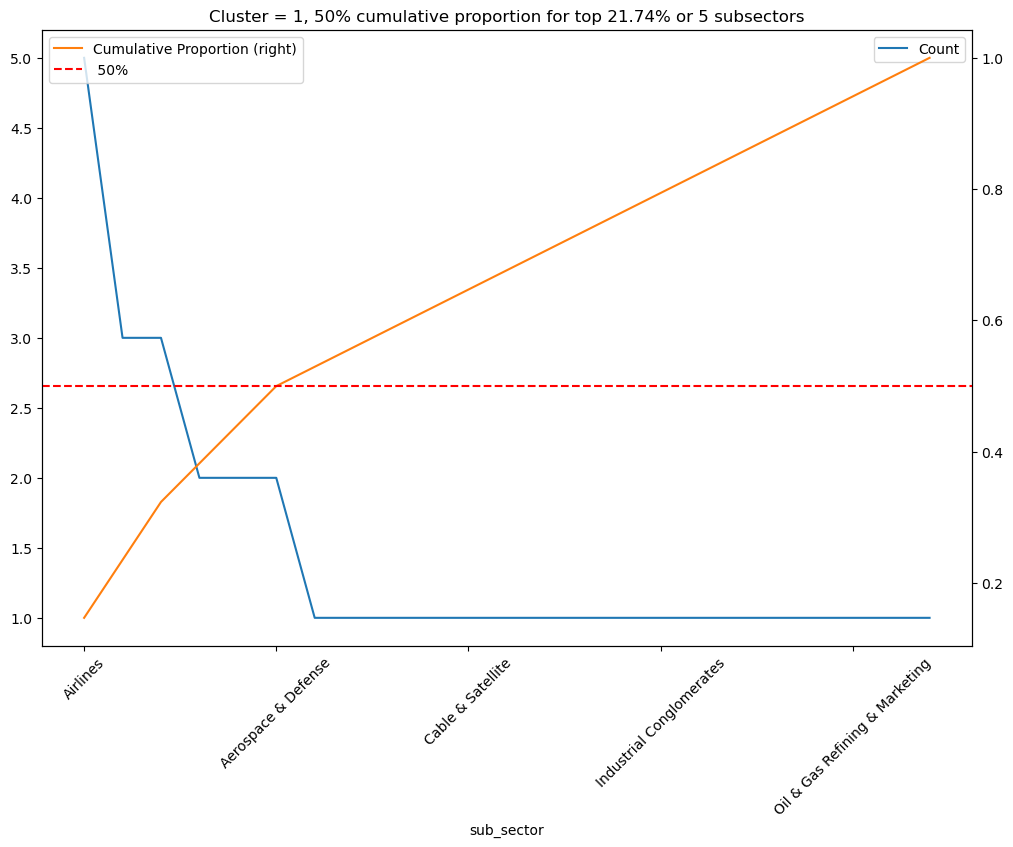

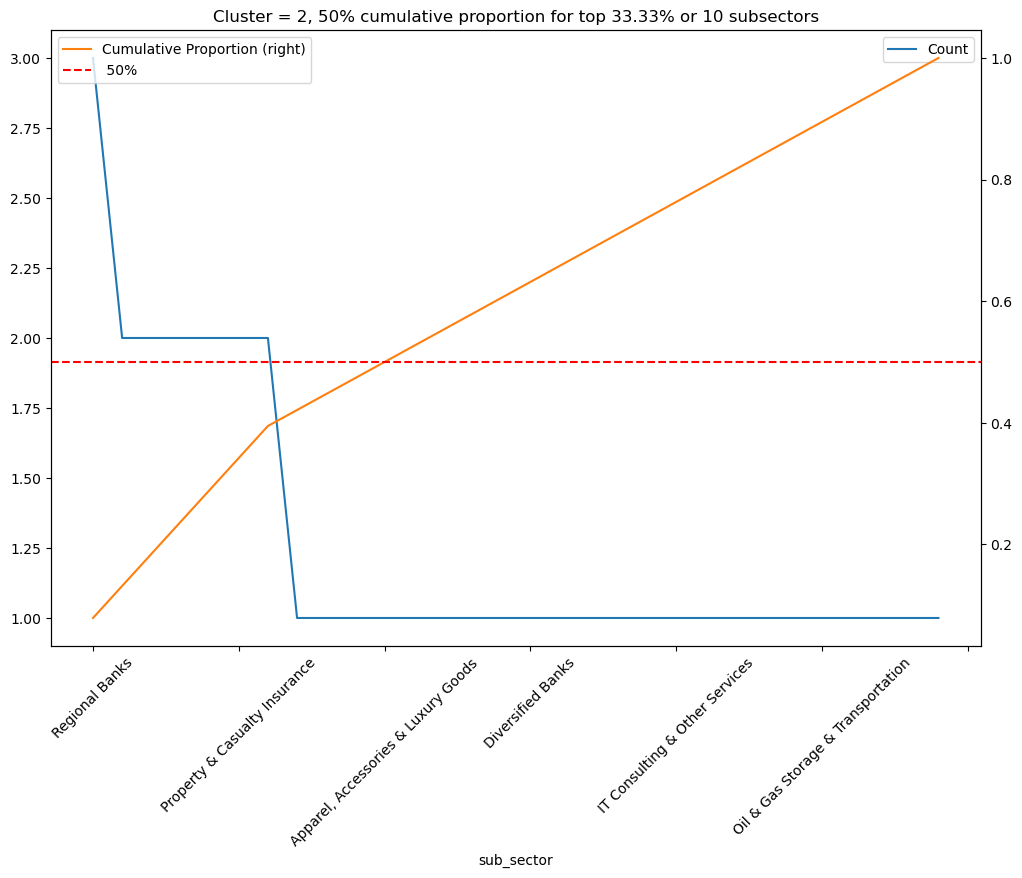

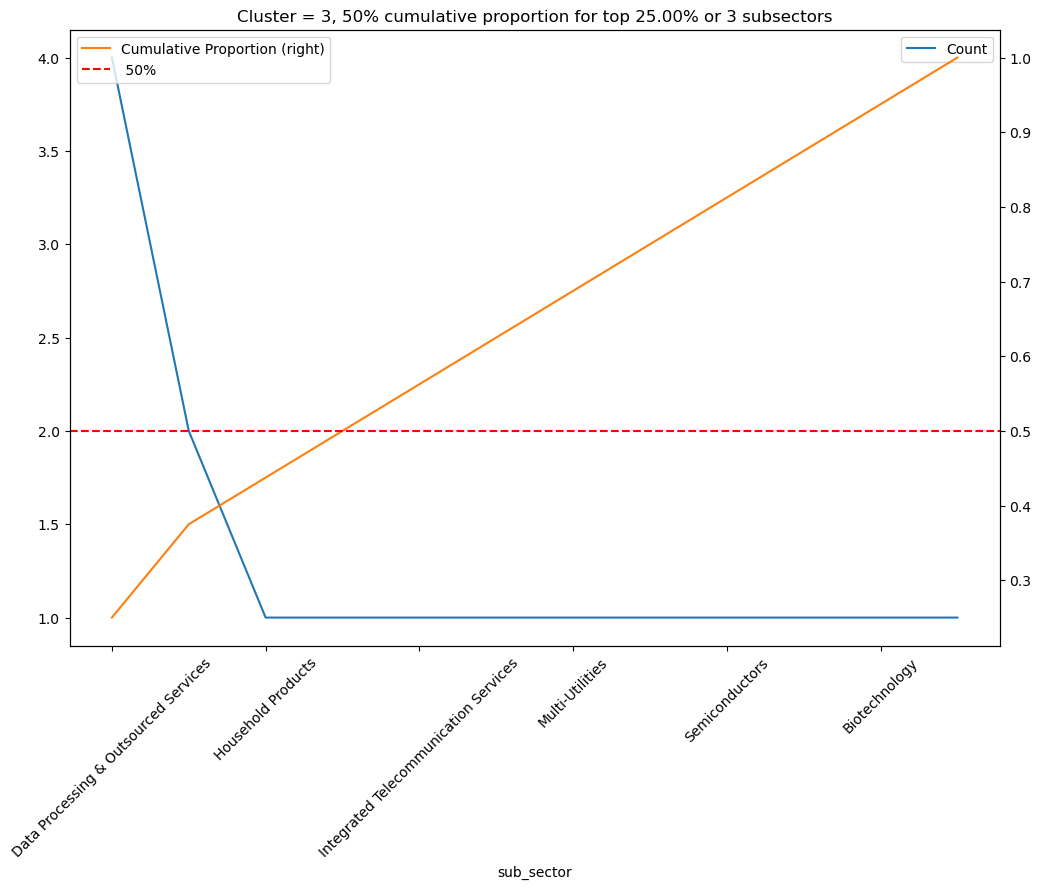

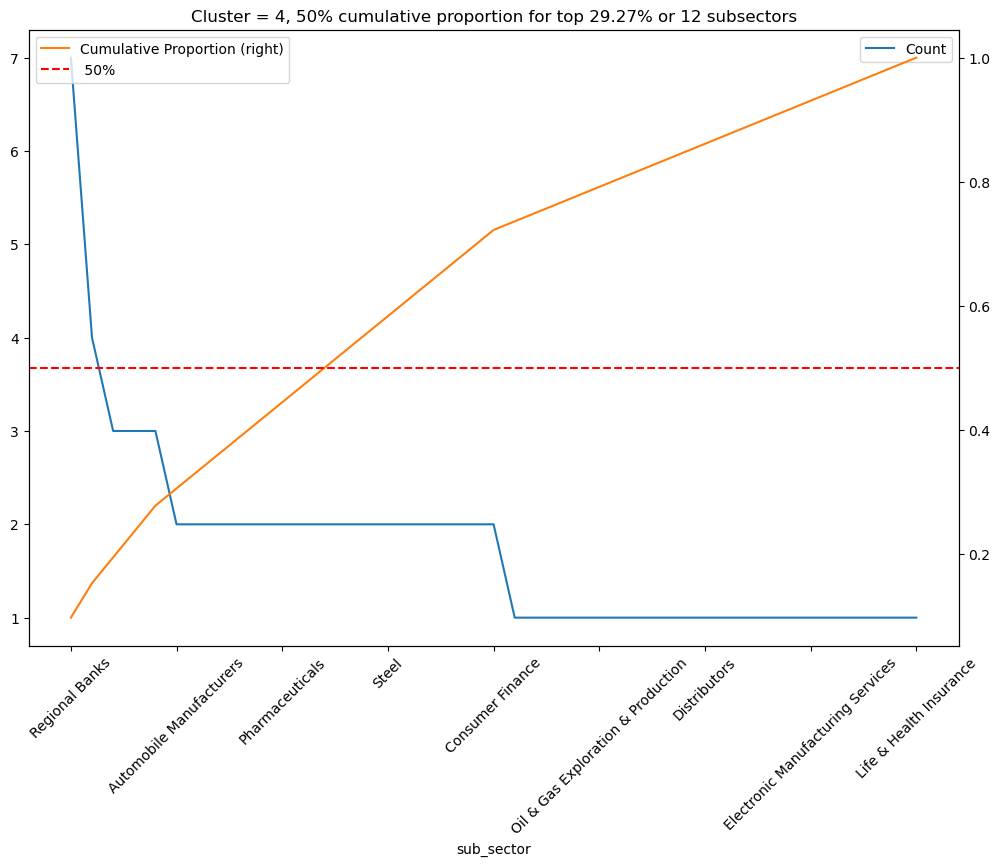

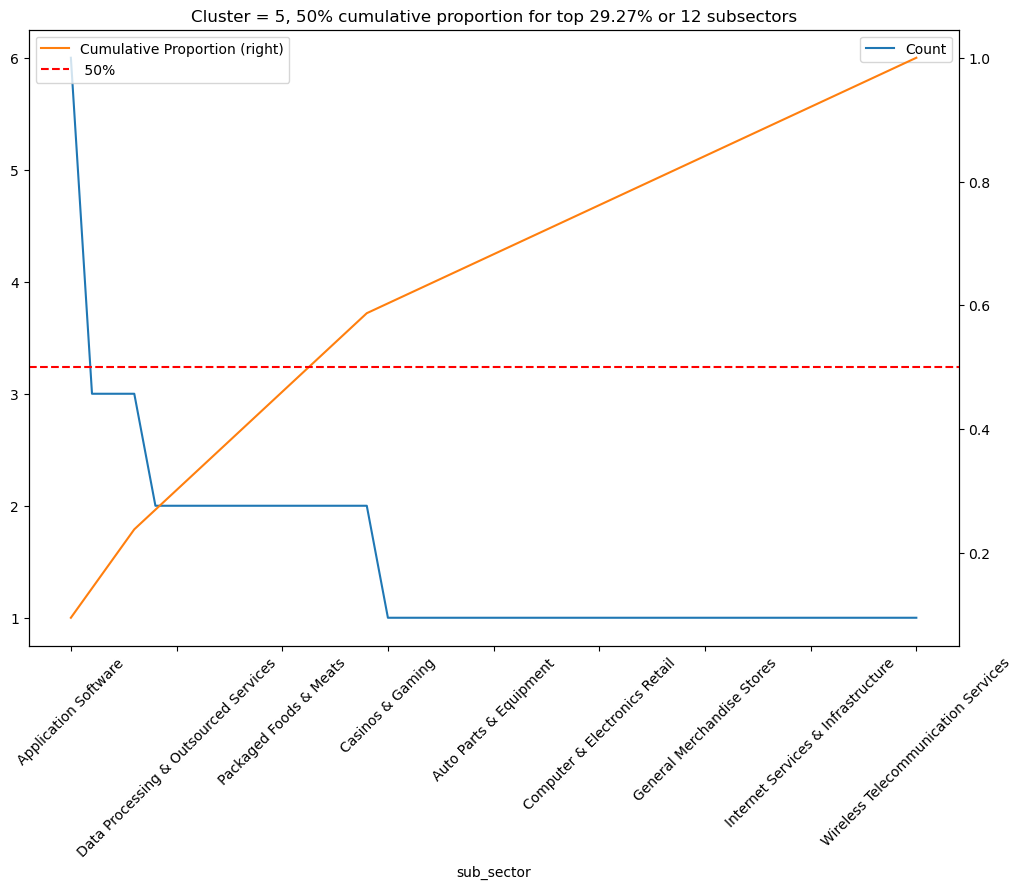

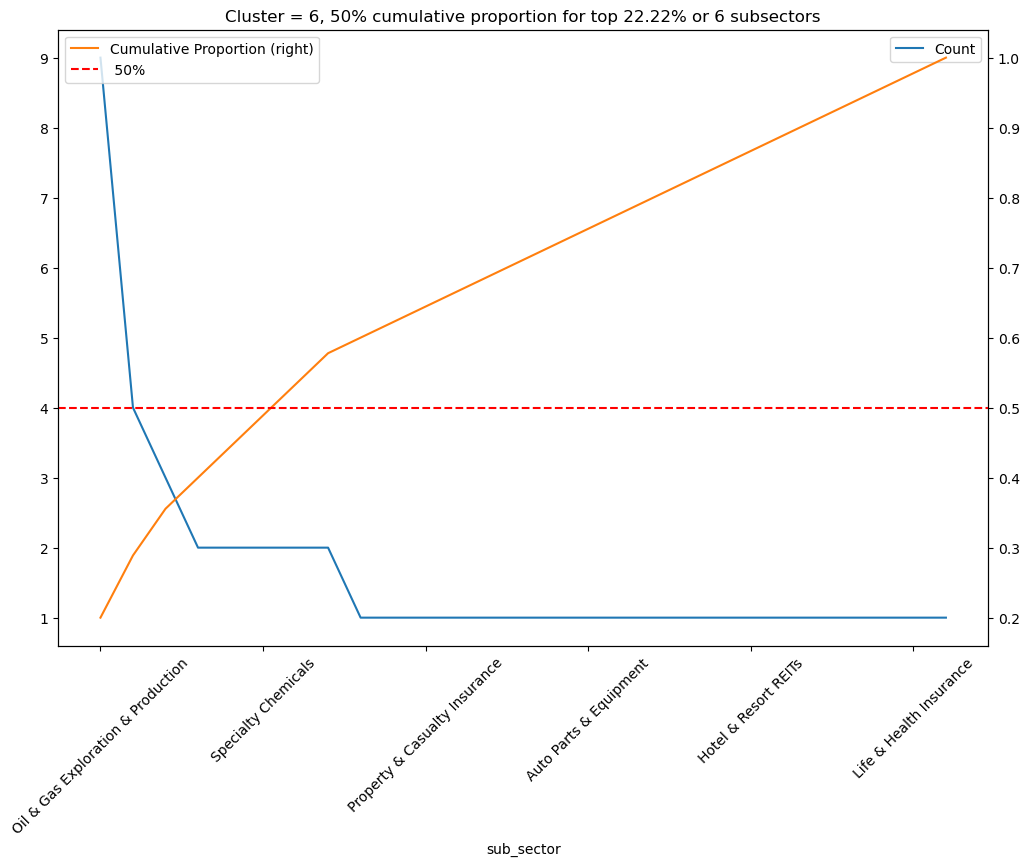

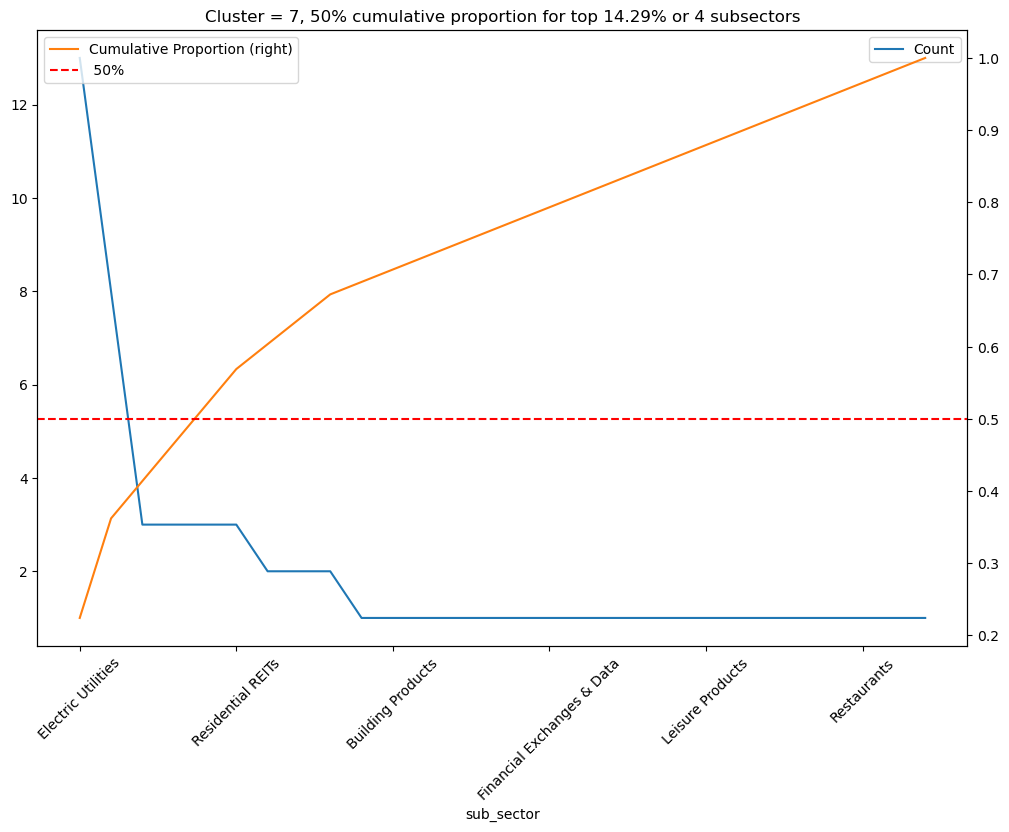

In [73]:
cluster_size = cross["predicted_label"].value_counts()
for k in range(8):
    fig,ax=plt.subplots()
    cross[["predicted_label","sub_sector"]].value_counts()[k].plot(rot = 45, label = "Count")
    plt.legend()
    proportion = cross[["predicted_label","sub_sector"]].value_counts()[k].cumsum()/cluster_size[k]
    ax = proportion.plot(rot = 45, secondary_y=True, label = "Cumulative Proportion")
    conc_ = (proportion<0.5).sum()
    conc = (conc_)/len(proportion)
    ax.axhline(0.5,color="red", linestyle = "dashed", label =" 50%")
    plt.title(f"Cluster = {k}, 50% cumulative proportion for top {conc:.2%} or {conc_} subsectors")
    plt.legend()

### Deep analysis

In [119]:
final_mask = cluster_1_stocks & biotech_stocks
cluster_1_stocks.shape

(479,)

In [116]:
close_prices.shape

(1060, 479)

In [125]:
cluster_1_stocks = cross.predicted_label == 1
biotech_stocks = cross.sub_sector == "Biotechnology"
final_mask = cluster_1_stocks & biotech_stocks
# (cluster_1_stocks & biotech_stocks).sum()
cross.loc[final_mask]

stokcs       sector     sub_sector  predicted_label
60    BIIB  Health Care  Biotechnology                1
188   GILD  Health Care  Biotechnology                1
224   INCY  Health Care  Biotechnology                1

In [128]:
df_ticker[df_ticker.Symbol.isin(["BIIB","GILD","INCY"])]

Symbol         Security SEC filings  GICS Sector GICS Sub-Industry  \
68    BIIB           Biogen     reports  Health Care     Biotechnology   
220   GILD  Gilead Sciences     reports  Health Care     Biotechnology   
249   INCY           Incyte     reports  Health Care     Biotechnology   

        Headquarters Location Date first added     CIK Founded  
68   Cambridge, Massachusetts       2003-11-13  875045    1978  
220   Foster City, California       2004-07-01  882095    1987  
249      Wilmington, Delaware       2017-02-28  879169    1991